In [1]:
import sys
sys.path.append("scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [146]:
class Dstar():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.real_grid_map = grid_map_world.grid_map #実際のマップ
        self.metric_grid_map = np.full(self.real_grid_map.shape, '-1')  #測定により得られたマップ
        self.cost_map = np.full(self.real_grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.real_grid_map.shape, 0)
        self.child_id_map = np.full(self.real_grid_map.shape, 0)
        
        self.h_map = np.full(self.real_grid_map.shape, 10000.0)
        self.k_map = np.full(self.real_grid_map.shape, 10000.0)
        
        self.robot_index = self.world.start_index
        self.flag_path_draw = 0  #経路描画のフラグ
        self.flag_map_update = False  #マップ更新のフラグ
        
        self.open_list = []
        self.closed_list = []
        
        #各グリッドのIDを登録，ゴール地点のコストを決定
        grid_id = 0
        for index_x, grids in enumerate(self.real_grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = grid_id;
                if(grid == '3'): #ゴール地点はコストをゼロにする
                    self.h_map[index_x][index_y] = 0
                    self.k_map[index_x][index_y] = 0
                    self.openAppend([index_x, index_y], 0)
                grid_id += 1
          
        #既知の地図を用いて各グリッドのコストを生成し，経路を生成する
        index = [0, 0]
        k_min = 0.0
        while(k_min != -1 and self.world.grid_map[index[0]][index[1]] != '2'):
            index = self.processState()
            if(index == [-1, -1]):
                k_min = -1
            else:
                k_min = self.k(index)

    def draw(self, ax, elems):
        #新しく障害物が見つかったかどうかを確認する
        self.flag_map_update = False
        for i in range(-3, 6):
                if(self.robot_index[0]+i<0 or self.robot_index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-3, 6):
                    if(self.robot_index[1]+j<0 or self.robot_index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue
                    elif(i==0 and j==0): #自分か
                        continue
                    elif(math.sqrt(i**2+j**2) >= 3):
                        continue
                    else:
                        neigbor_index = [self.robot_index[0]+i, self.robot_index[1]+j]
                        if(self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] == '-1'):  #まだ探索していないグリッドの場合
                            self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] = self.real_grid_map[neigbor_index[0]][neigbor_index[1]]
                            if(self.real_grid_map[neigbor_index[0]][neigbor_index[1]] == '0'):  #新しい障害物の場合
                                r = patches.Rectangle(
                                    xy=((self.robot_index[0]+i)*self.world.grid_step[0], (self.robot_index[1]+j)*self.world.grid_step[1]),
                                    height=self.world.grid_step[0],
                                    width=self.world.grid_step[1],
                                    color="black",
                                    fill=True
                                )
                                ax.add_patch(r)
                                obstacle_index = [self.robot_index[0]+i, self.robot_index[1]+j]
                                self.insert(obstacle_index, self.h(obstacle_index))
                                self.h_map[obstacle_index[0]][obstacle_index[1]] = 10000  #障害物のコストを無限大にする
                                
                                #周囲のグリッドをオープンリストに追加する
                                for k in range(-1, 2):
                                    if(self.robot_index[0]+i+k<0 or self.robot_index[0]+i+k>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                                        continue;
                                    for l in range(-1, 2):
                                        if(self.robot_index[1]+j+l<0 or self.robot_index[1]+j+l>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                                            continue;
                                        if(k==0 and l==0): #自分か
                                            continue;
                                        elif(self.metric_grid_map[self.robot_index[0]+i+k][self.robot_index[1]+j+l] == '0'): #障害物か
                                            continue;
                                        else:
                                            neigbor_index = [self.robot_index[0]+i+k, self.robot_index[1]+j+l]
                                            self.insert(neigbor_index, self.k(neigbor_index))
                        else:
                            pass
        
        k_min = 0.0
        h_now = self.h(self.robot_index)
        while(k_min != -1 and k_min < h_now):
            index = self.processState()
            if(index == [-1, -1]):
                k_min = -1
            else:
                k_min = self.k(index)
        
        #経路の描画
        child_id = self.id(self.robot_index)
        while(child_id != self.id(self.world.goal_index)):  #ゴールになるまでたどる
            child = np.where(self.id_map==child_id)
            child_id = self.child_id_map[int(child[0])][int(child[1])]
            r = patches.Rectangle(
                xy=((child[0])*self.world.grid_step[0], (child[1])*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True
            )
            elems.append(ax.add_patch(r))
            
        #ロボットの描画
        r = patches.Rectangle(
            xy=((self.robot_index[0])*self.world.grid_step[0], (self.robot_index[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color="cyan",
            fill=True
        )
        ax.add_patch(r)
        r = patches.Rectangle(
            xy=((self.robot_index[0])*self.world.grid_step[0], (self.robot_index[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color="blue",
            fill=True
        )
        elems.append(ax.add_patch(r))
        
        if(self.id(self.robot_index) != self.id(self.world.goal_index)): #ロボットがゴールに到達していなければ，子ノードに移動する
            child_id = self.child_id_map[self.robot_index[0]][self.robot_index[1]]
            child = np.where(self.id_map==child_id)
            self.robot_index = [int(child[0]), int(child[1])]

    def processState(self):
        index = self.getMinKGrid()
        if(index == None):
            return [-1, -1]
        if(index == [-1, -1]):
            return [-1, -1]
        k_old = self.k(index)
        self.closeAppend(index)
        
        if(k_old < self.h(index)):
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    #elif(self.metric_grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                    #    continue;
                    else:
                        neigbor_index = [index[0]+i, index[1]+j]
                        cost_h_new = self.h(neigbor_index) + self.c(index, neigbor_index)
                        if(
                            self.isNewGrid(neigbor_index) == False and
                            self.h(neigbor_index) <= k_old and
                            self.isHlarger(self.h(index), cost_h_new)
                        ):
                            self.child_id_map[index[0]][index[1]] = self.id(neigbor_index)
                            self.h_map[index[0]][index[1]] = self.h(neigbor_index) + self.c(index, neigbor_index)
        
        if(self.isHsame(k_old, self.h(index))):
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    #elif(self.metric_grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                    #    continue;
                    else:
                        neigbor_index = [index[0]+i, index[1]+j]
                        cost_h_new = self.h(index)+self.c(index, neigbor_index)
                        if(
                            self.isNewGrid(neigbor_index) or
                            (self.b(neigbor_index)==self.id(index) and self.isHsame(self.h(neigbor_index), cost_h_new)==False) or
                            (self.b(neigbor_index)!=self.id(index) and self.isHlarger(self.h(neigbor_index), cost_h_new))
                        ):
                            self.child_id_map[neigbor_index[0]][neigbor_index[1]] = self.id(index)
                            self.insert(neigbor_index, cost_h_new)                 
        else:
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    #elif(self.metric_grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                    #    continue;
                    else:
                        neigbor_index = [index[0]+i, index[1]+j]
                        cost_h_new = self.h(index) + self.c(index, neigbor_index)
                        if(
                            self.isNewGrid(neigbor_index) or
                            (self.b(neigbor_index)==self.id(index) and self.isHsame(self.h(neigbor_index), cost_h_new)==False)
                        ):
                            self.child_id_map[neigbor_index[0]][neigbor_index[1]] = self.id(index)
                            self.insert(neigbor_index, cost_h_new)
                        elif(
                            self.b(neigbor_index) != self.id(index) and
                            self.isHlarger(self.h(neigbor_index), cost_h_new)
                        ):
                            self.insert(index, self.h(index))
                        elif(
                            self.b(neigbor_index) != self.id(index) and
                            self.isHlarger(self.h(index), self.h(neigbor_index) + self.c(index, neigbor_index)) and
                            self.isClosedGrid(neigbor_index) and
                            self.h(neigbor_index)>k_old
                        ):
                            self.insert(neigbor_index, self.h(neigbor_index))
                        else:
                            pass

        index = self.getMinKGrid()        
        return index
    
    def isOpenedGrid(self, index): #オープンリストかどうか
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return True
        else:
            return False
        
    def isClosedGrid(self, index):  #クローズリストかどうか
        if(self.id_map[index[0]][index[1]] in self.closed_list):
            return True
        else:
            return False
        
    def isNewGrid(self, index):  #新しいグリッドか（オープンでもなくクローズでもない）
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return False
        elif(self.id_map[index[0]][index[1]] in self.closed_list):
            return False
        else:
            return True
    
    def insert(self, index, h_new):
        if(h_new > 10000):
            h_new = 10000
        if(self.isNewGrid(index) == True):
            k = h_new
        elif(self.isOpenedGrid(index) == True):
            if(self.k(index) > h_new):
                k = h_new
            else:
                k = self.k(index)
        elif(self.isClosedGrid(index) == True):
            if(self.h(index) > h_new):
                k = h_new
            else:
                k = self.h(index)
        self.openAppend(index, k)
        self.k_map[index[0]][index[1]] = k
        self.h_map[index[0]][index[1]] = h_new
        
    def openAppend(self, index, cost_k):
        if(self.isOpenedGrid(index) == True):
            if(self.k(index) != cost_k):
                self.open_list.remove([self.id(index), self.k(index)])
                self.open_list.append([self.id(index), cost_k])
            return
        elif(self.isClosedGrid(index) == True):
            self.closed_list.remove(self.id(index))
        self.open_list.append([self.id(index), cost_k])
    
    def closeAppend(self, index):
        if(self.isOpenedGrid(index) == True):
            self.open_list.remove([self.id(index), self.k(index)])
        elif(self.isClosedGrid(index) == True):
            return
        self.closed_list.append(self.id(index))
    
    def getMinKGrid(self):
        if(self.open_list == []):
            return [-1, -1]
        val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
        grid_id = self.open_list[val[1]][0]
        index = np.where(self.id_map==grid_id)
        return [index[0][0], index[1][0]]
    
    def isHsame(self, cost_h1, cost_h2):
        if(cost_h1 == cost_h2):
            return True
        else:
            if(cost_h1 >= 10000 and cost_h2 >= 10000):
                return True
            else:
                return False
    
    def isHlarger(self, cost_h1, cost_h2):
        if(cost_h1 >= 10000 and cost_h2 >= 10000):
            return False
        else:
            if(cost_h1 > cost_h2):
                return True
            else:
                return False
    
    def h(self, index):
        return self.h_map[index[0]][index[1]]
        
    def k(self, index):
        return self.k_map[index[0]][index[1]]
    
    def b(self, index):  #子ノードのidを返す
        return self.child_id_map[index[0]][index[1]]
    
    def c(self, index, neigbor_index): #隣接ノードへ移動するのに要するコスト
        if(self.metric_grid_map[index[0]][index[1]] == '0' or self.metric_grid_map[neigbor_index[0]][neigbor_index[1]] == '0'):
            return 10000
        else:
            if((neigbor_index[0]-index[0])**2 + (neigbor_index[1]-index[1])**2 > 1.4):
                return 1.41421356
            else:
                return 1.0

    def id(self, index):
        return self.id_map[index[0]][index[1]]

<IPython.core.display.Javascript object>


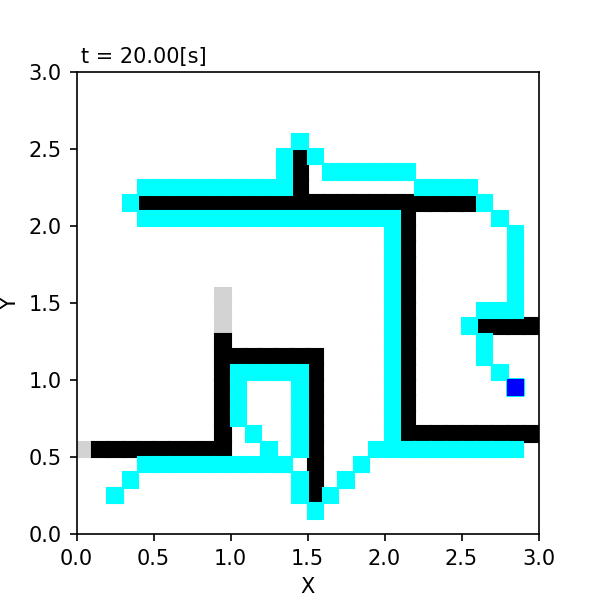

In [153]:
if __name__ == "__main__":
    time_span = 20
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False, isDynamic=True)
    world.append(Dstar(world))
    
    world.draw()
    #world.ani.save('dstar_map2.gif', writer='pillow', fps=100)    #アニメーション保存